Importing needed libraries

In [1]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as trfms

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from datasets import load_from_disk

/home/denis/Coding/projects/TESTImageSegmentation/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Selecting CUDA device if available. Set multiprocessing method to 'spawn' instead of 'fork' as it works better on UNIX-system.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.multiprocessing.set_start_method('spawn', force=True)

Loading dataset

In [3]:
dataset = load_from_disk("./data/urbansyncityscapes")
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']

Some samples

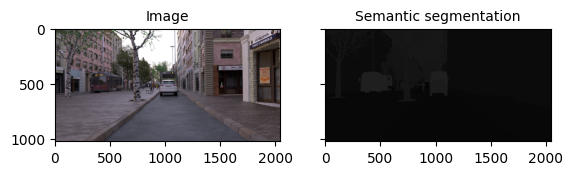

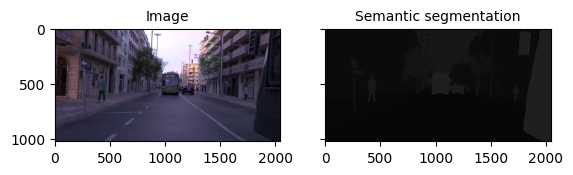

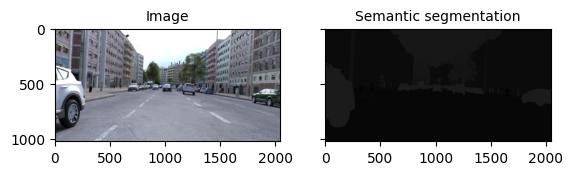

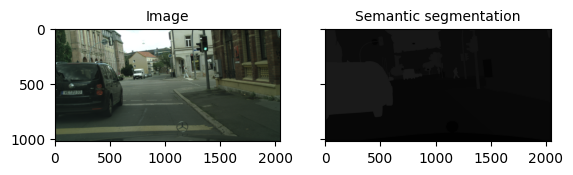

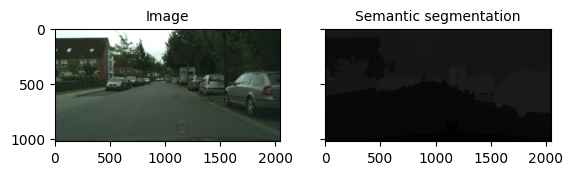

In [4]:
for i in range(5):
    example = dataset_train[i]
    image = example['image']
    semantic_segmentation = example['semantic_segmentation']
    fig = plt.figure()
    ax1, ax2 = fig.subplots(1, 2, sharey=True)
    ax1.imshow(image)
    ax1.set_title('Image', fontsize='medium')
    ax2.imshow(semantic_segmentation)
    ax2.set_title('Semantic segmentation', fontsize='medium')


Specifying augmentation for train and validation set. Test set would be used without any augmentation. 

In [5]:
class InstanceAugmentation:
    """
    Transformation of both image and mask. Geometric transformation would be
    in alignment with each other. Color transformation is applied specifically
    for image.
    """
    def __init__(self, geometry_transform = None, color_transform = None):
        self.geometry_transform = geometry_transform
        self.color_transform = color_transform

    def __call__(self, image, mask):
        if self.geometry_transform:
            seed = random.randint(0, 2**32)
            torch.manual_seed(seed)
            image = self.geometry_transform(image)
            torch.manual_seed(seed)
            mask = self.geometry_transform(mask)

        if self.color_transform:
            image = self.color_transform(image)

        return image, mask

In [6]:
train_transforms_geometry = trfms.Compose([
    trfms.RandomHorizontalFlip(),
    trfms.RandomApply(transforms=[
        trfms.Resize(size=(512, 512))
    ], p=0.5),
    trfms.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.3))
])
train_transforms_color = trfms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.4, hue=0.3)

train_transform = InstanceAugmentation(train_transforms_geometry, train_transforms_color)

In [7]:
val_transforms_geometry = trfms.Compose([
    trfms.RandomHorizontalFlip(),
    trfms.RandomAffine(degrees=(-15, 15), scale=(0.8, 1.2)),
])
val_transforms_color = trfms.ColorJitter(brightness=0.1, contrast=0.1)

val_transform = InstanceAugmentation(val_transforms_geometry, val_transforms_color)

Augmented samples

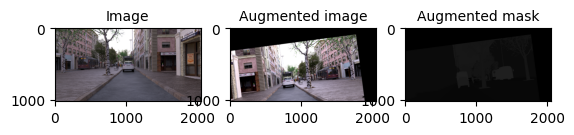

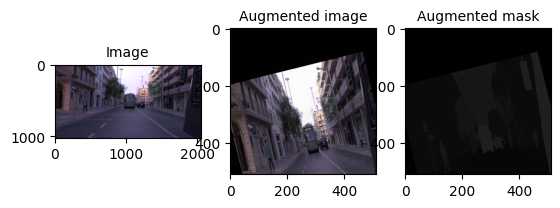

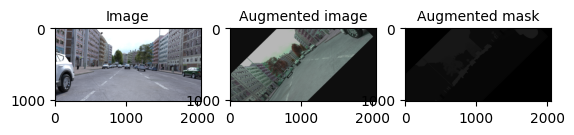

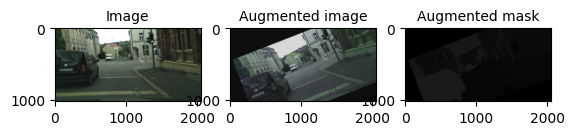

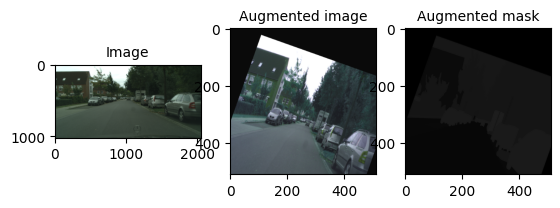

In [8]:
for i in range(5):
    example = dataset_train[i]
    image = example['image']
    semantic_segmentation = example['semantic_segmentation']
    aug_image, aug_mask = train_transform(image, semantic_segmentation)
    fig = plt.figure()
    ax1, ax2, ax3 = fig.subplots(1, 3)
    ax1.imshow(np.array(image))
    ax1.set_title('Image', fontsize='medium')
    ax2.imshow(aug_image)
    ax2.set_title('Augmented image', fontsize='medium')
    ax3.imshow(aug_mask)
    ax3.set_title('Augmented mask', fontsize='medium')

Making a pytorch Dataset compatible with transformations 

In [9]:
class StreetSegmentationDataset(Dataset):
    def __init__(self, dataset, transform  = None):
        super().__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx : int):
        sample = self.dataset[idx]
        image = sample['image']
        mask = sample['semantic_segmentation']

        if self.transform:
            image, mask = self.transform(image, mask)

        image = torch.Tensor(np.array(image)).float()/255
        mask = torch.Tensor(np.array(mask)).long()[:, :, 0]
        return image, mask

In [10]:
train_ds = StreetSegmentationDataset(dataset_train, train_transform)
val_ds = StreetSegmentationDataset(dataset_val, val_transform)
test_ds = StreetSegmentationDataset(dataset_test)

In [15]:
def collate_fn(batch):
    images, masks = zip(*batch)
    max_height = max(img.shape[0] for img in images)
    max_width = max(img.shape[1] for img in images)

    padded_images = []
    padded_masks = []
    original_sizes = []
    for img, mask in zip(images, masks):
        height, width, channels = img.shape
        padded_img = torch.zeros((max_height, max_width, channels), dtype=img.dtype)
        padded_img[:height, :width, :] = img

        padded_mask = torch.zeros((max_height, max_width), dtype=mask.dtype)
        padded_mask[:height, :width] = mask

        padded_images.append(padded_img)
        padded_masks.append(padded_mask)
        original_sizes.append((height, width))

    padded_images = torch.stack(padded_images, dim=0)
    padded_masks = torch.stack(padded_masks, dim=0)

    return padded_images, padded_masks, original_sizes

In [16]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_dataloader = DataLoader(val_ds, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)

torch.Size([1024, 2048, 3]) torch.Size([1024, 2048])
torch.Size([1024, 2048, 3]) torch.Size([1024, 2048])
torch.Size([1024, 2048, 3]) torch.Size([1024, 2048])
torch.Size([1024, 2048, 3]) torch.Size([1024, 2048])
torch.Size([1024, 2048, 3]) torch.Size([1024, 2048])


/tmp/ipykernel_29590/2096961084.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ax1.imshow(np.array(image))


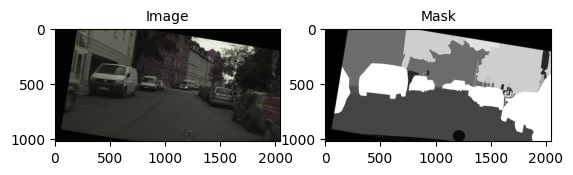

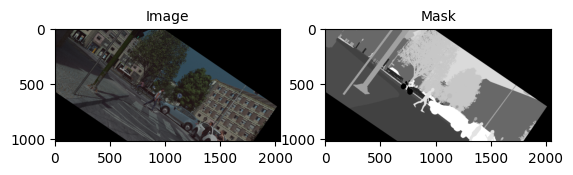

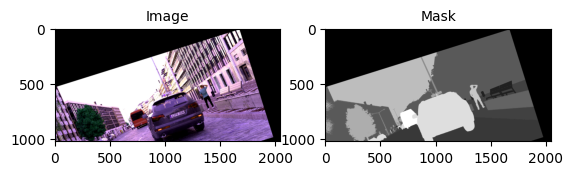

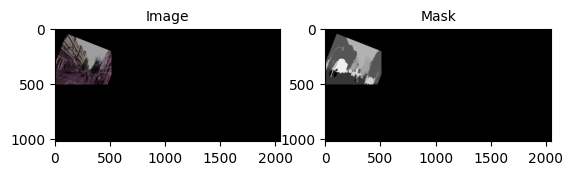

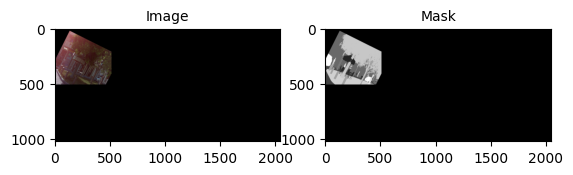

In [23]:
for sample in train_dataloader:
    for i in range(5):
        image, mask = sample[0][i], sample[1][i]
        print(image.shape, mask.shape)
        fig = plt.figure()
        ax1, ax2 = fig.subplots(1, 2)
        ax1.imshow(np.array(image))
        ax1.set_title('Image', fontsize='medium')
        ax2.imshow(mask, cmap='gray')
        ax2.set_title('Mask', fontsize='medium')
    break